In [1]:
# Import Libaries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'D:\Data Science\Capstone Project\Capstone Project 3\bike_sharing\data\raw\data_bike_sharing.csv')

In [3]:
df['dteday'] = pd.to_datetime(df['dteday'])

In [4]:
df = df.rename(columns={'dteday': 'date','weathersit': 'weather','atemp':'feeling_temp', 'hum': 'humidity','hr':'hour', 'cnt': 'count'})

In [5]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day_of_week

df = df.drop(['date','casual','registered'], axis=1)

In [6]:
print('Total number of duplicated rows:', df.duplicated().sum())

Total number of duplicated rows: 1


In [7]:
df = df.drop_duplicates()

In [8]:
df

,humidity,weather,holiday,season,feeling_temp,temp,hour,count,year,month,day
0,0.62,1,0,4,0.3485,0.36,16,250,2011,12,4
1,0.64,1,0,2,0.5152,0.54,4,18,2012,6,6
2,0.53,1,0,2,0.6212,0.62,23,107,2011,6,2
3,0.87,2,0,2,0.3485,0.36,8,145,2012,3,5
4,0.55,1,0,3,0.6970,0.76,18,857,2012,7,1
...,...,...,...,...,...,...,...,...,...,...,...
12160,0.75,1,0,1,0.2273,0.24,7,257,2012,1,2
12161,0.62,1,0,3,0.7424,0.78,0,102,2012,7,4
12162,0.60,2,1,1,0.2121,0.24,5,6,2012,2,0
12163,0.77,2,0,2,0.4242,0.42,2,69,2012,3,5


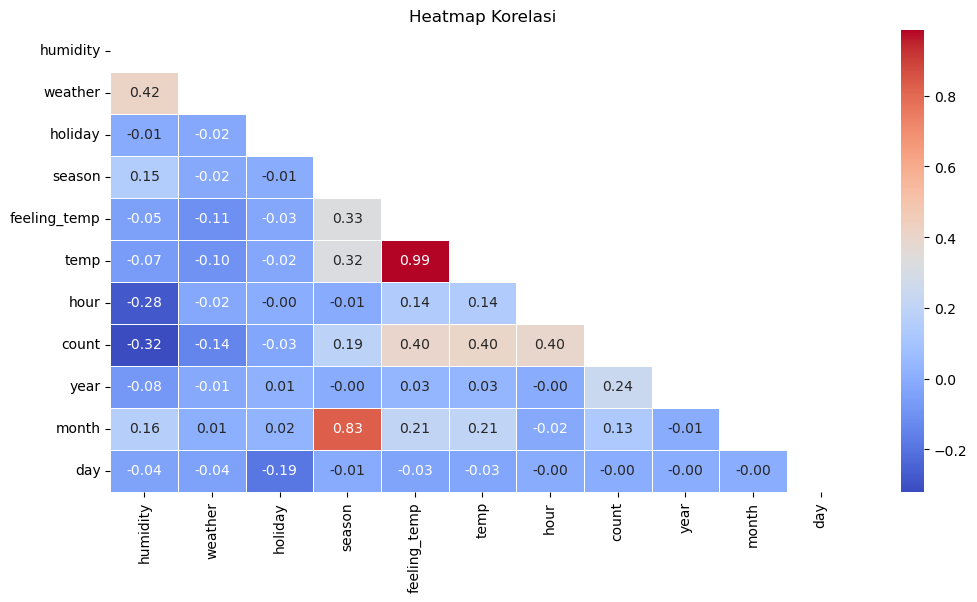

In [9]:
# Hitung korelasi
correlation_matrix = df.corr()
up_triangle = np.triu(df.corr())

# Plot heatmap korelasi
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True,mask=up_triangle, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi')
plt.show()

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [11]:
# Calculating VIF
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [12]:
calc_vif(df[[i for i in df.describe().columns if i not in ['count']]])

,variables,VIF
0,humidity,16.188475
1,weather,7.451503
2,holiday,1.075556
3,season,20.861719
4,feeling_temp,353.320869
5,temp,311.362402
6,hour,4.222269
7,year,31.597858
8,month,14.822409
9,day,3.417027


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12164 entries, 0 to 12164
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   humidity      12164 non-null  float64
 1   weather       12164 non-null  int64  
 2   holiday       12164 non-null  int64  
 3   season        12164 non-null  int64  
 4   feeling_temp  12164 non-null  float64
 5   temp          12164 non-null  float64
 6   hour          12164 non-null  int64  
 7   count         12164 non-null  int64  
 8   year          12164 non-null  int32  
 9   month         12164 non-null  int32  
 10  day           12164 non-null  int32  
dtypes: float64(3), int32(3), int64(5)
memory usage: 997.8 KB


In [14]:
from sklearn.model_selection import train_test_split

df_seen, df_unseen = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
feature = df_seen.drop('count', axis=1)
target = df_seen['count']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)

print('feature_train shape:', X_train.shape)
print('target_train shape:', y_train.shape)

feature_train shape: (7784, 10)
target_train shape: (7784,)


In [17]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.creation import CyclicalFeatures

In [18]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9731 entries, 10288 to 7270
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   humidity      9731 non-null   float64
 1   weather       9731 non-null   int64  
 2   holiday       9731 non-null   int64  
 3   season        9731 non-null   int64  
 4   feeling_temp  9731 non-null   float64
 5   temp          9731 non-null   float64
 6   hour          9731 non-null   int64  
 7   year          9731 non-null   int32  
 8   month         9731 non-null   int32  
 9   day           9731 non-null   int32  
dtypes: float64(3), int32(3), int64(4)
memory usage: 722.2 KB


In [19]:
# Pipeline untuk Fitur Siklik
cyclical_transformer = Pipeline([
    ('cyclical_features', CyclicalFeatures(
        variables=['hour', 'day', 'month'],  # Fitur siklik
        max_values={'hour': 24, 'day': 31, 'month': 12}  # Nilai maksimum untuk setiap fitur siklik
    ))
])

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        # Passthrough = ['temp', 'feeling_temp', 'humidity', 'holiday', 'year']
        ('cyclic', cyclical_transformer, ['hour', 'day', 'month']),  # Transformasi siklik
        ('ohe', OneHotEncoder(), ['weather','season'])  # Encoding kategorikal
    ],
    remainder='passthrough', verbose_feature_names_out=False  # Biarkan fitur lainnya tetap
)

In [21]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cyclic',
                                 Pipeline(steps=[('cyclical_features',
                                                  CyclicalFeatures(max_values={'day': 31,
                                                                               'hour': 24,
                                                                               'month': 12},
                                                                   variables=['hour',
                                                                              'day',
                                                                              'month']))]),
                                 ['hour', 'day', 'month']),
                                ('ohe', OneHotEncoder(),
                                 ['weather', 'season'])],
                  verbose_feature_names_out=False)

In [22]:
X_train_pre = preprocessor.transform(X_train)
X_test_pre = preprocessor.transform(X_test)

In [23]:
# DataFrame
X_train_pre = pd.DataFrame(X_train_pre, columns=preprocessor.get_feature_names_out())
X_test_pre = pd.DataFrame(X_test_pre, columns=preprocessor.get_feature_names_out())

In [24]:
X_train_pre.head()

,hour,day,month,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,weather_1,...,weather_4,season_1,season_2,season_3,season_4,humidity,holiday,feeling_temp,temp,year
0,20.0,4.0,6.0,-0.866025,0.500000,0.724793,0.688967,1.224647e-16,-1.000000e+00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.55,0.0,0.6970,0.76,2012.0
1,10.0,3.0,2.0,0.500000,-0.866025,0.571268,0.820763,8.660254e-01,5.000000e-01,1.0,...,0.0,1.0,0.0,0.0,0.0,0.42,0.0,0.1061,0.12,2011.0
2,3.0,1.0,9.0,0.707107,0.707107,0.201299,0.979530,-1.000000e+00,-1.836970e-16,0.0,...,0.0,0.0,0.0,1.0,0.0,0.94,0.0,0.5455,0.62,2012.0
3,2.0,4.0,7.0,0.500000,0.866025,0.724793,0.688967,-5.000000e-01,-8.660254e-01,0.0,...,0.0,0.0,0.0,1.0,0.0,0.61,0.0,0.6212,0.66,2012.0
4,20.0,6.0,5.0,-0.866025,0.500000,0.937752,0.347305,5.000000e-01,-8.660254e-01,1.0,...,0.0,0.0,1.0,0.0,0.0,0.77,0.0,0.5000,0.52,2011.0


In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# errors
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# cross validation
from sklearn.model_selection import cross_val_score, cross_validate, KFold

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# transformed target regressor
from sklearn.compose import TransformedTargetRegressor

In [26]:
from sklearn.model_selection import KFold, cross_validate

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, enable_categorical=True),
    "LightGBM": LGBMRegressor(random_state=42)
}

scorer = [
    "neg_root_mean_squared_error", 
    "neg_mean_absolute_error", 
    "neg_mean_absolute_percentage_error"
    ]

# Benchmarking models
benchmark_results = {}
for idx, model in enumerate(models):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', models[model])
    ])

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_score = cross_validate(
        estimator=pipeline,
        X = X_train,
        y = y_train,
        cv = cv,
        scoring=scorer,
        error_score='raise',
    )

    benchmark_results[model] = {
        'Mean RMSE': cv_score['test_neg_root_mean_squared_error'].mean(),
        'Std RMSE': cv_score['test_neg_root_mean_squared_error'].std(),
        'Mean MAPE': cv_score['test_neg_mean_absolute_percentage_error'].mean(),
        'Std MAPE': cv_score['test_neg_mean_absolute_percentage_error'].std(),
        'Mean MAE': cv_score['test_neg_mean_absolute_error'].mean(),
        'Std MAE': cv_score['test_neg_mean_absolute_error'].std(),
    }

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 6227, number of used features: 21
[LightGBM] [Info] Start training from score 188.851453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 6227, number of used features: 21
[LightGBM] [Info] Start training from score 188.220652
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set:

In [27]:
# Convert benchmark results to DataFrame for analysis
benchmark_df = pd.DataFrame(benchmark_results).T.sort_values(by="Mean RMSE", ascending=False)

# Display benchmarking results
print("\nBenchmarking Results:")
benchmark_df


Benchmarking Results:


,Mean RMSE,Std RMSE,Mean MAPE,Std MAPE,Mean MAE,Std MAE
LightGBM,-41.879116,1.496537,-0.400876,0.029664,-26.556050,0.670826
XGBoost,-43.598633,1.572770,-0.436612,0.044564,-27.778376,0.719650
Random Forest,-47.361651,2.452754,-0.365621,0.027413,-29.151999,0.823759
Decision Tree,-66.092692,2.145112,-0.428830,0.030856,-39.726427,1.461669
Gradient Boosting,-68.092449,3.245504,-1.079471,0.190684,-46.804959,1.626438
Linear Regression,-126.167367,2.024636,-2.700769,0.278872,-92.862912,0.543681
Ridge Regression,-126.192621,1.998751,-2.702347,0.277677,-92.847542,0.505839
Lasso Regression,-126.920492,2.161598,-2.598034,0.283536,-92.949869,0.655199


In [28]:
from sklearn.model_selection import KFold, cross_validate
import pandas as pd

# Inisialisasi dictionary untuk menyimpan hasil
benchmark_results1 = {}

# Loop untuk setiap model
for idx, model in enumerate(models):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', models[model])
    ])
    
    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=19)
    
    cv_results = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        cv=cv,
        scoring=scorer,
        return_train_score=True,  # Tambahkan ini untuk mengukur train score
        error_score='raise',
    )
    
    # Simpan hasil ke dictionary
    benchmark_results1[model] = {
        'Train RMSE': -cv_results['train_neg_root_mean_squared_error'].mean(),
        'Test RMSE': -cv_results['test_neg_root_mean_squared_error'].mean(),
        'Train MAPE': -cv_results['train_neg_mean_absolute_percentage_error'].mean(),
        'Test MAPE': -cv_results['test_neg_mean_absolute_percentage_error'].mean(),
        'Train MAE': -cv_results['train_neg_mean_absolute_error'].mean(),
        'Test MAE': -cv_results['test_neg_mean_absolute_error'].mean(),
        'RMSE Gap': -cv_results['test_neg_root_mean_squared_error'].mean() - 
                    -cv_results['train_neg_root_mean_squared_error'].mean(),
        'MAPE Gap': -cv_results['test_neg_mean_absolute_percentage_error'].mean() - 
                    -cv_results['train_neg_mean_absolute_percentage_error'].mean(),
    }

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 6227, number of used features: 21
[LightGBM] [Info] Start training from score 190.071784
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 6227, number of used features: 21
[LightGBM] [Info] Start training from score 188.993095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [29]:
# Konversi hasil ke DataFrame untuk analisis
results_df = pd.DataFrame(benchmark_results1).T

# Tampilkan hasil
results_df

,Train RMSE,Test RMSE,Train MAPE,Test MAPE,Train MAE,Test MAE,RMSE Gap,MAPE Gap
Linear Regression,125.873355,126.164644,2.684894,2.700388,92.583673,92.843252,0.291289,0.015494
Ridge Regression,125.917399,126.170477,2.686888,2.702020,92.587619,92.818021,0.253078,0.015132
Lasso Regression,126.717144,126.914328,2.585201,2.598556,92.761550,92.925080,0.197185,0.013354
Decision Tree,1.241046,65.172218,0.000144,0.432710,0.041442,39.029088,63.931172,0.432566
Random Forest,18.007258,47.285415,0.135534,0.365715,10.899310,29.132385,29.278156,0.230181
Gradient Boosting,63.787598,66.314735,0.984135,0.999353,43.679554,45.388017,2.527136,0.015218
XGBoost,21.123098,43.618767,0.252807,0.415984,14.206575,27.378956,22.495669,0.163177
LightGBM,32.694138,41.853039,0.352786,0.396909,21.462693,26.521455,9.158901,0.044122


In [30]:
log_linear = TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)
log_ridge = TransformedTargetRegressor(Ridge(random_state=42), func=np.log, inverse_func=np.exp)
log_lasso = TransformedTargetRegressor(Lasso(random_state=42), func=np.log, inverse_func=np.exp)
log_tree = TransformedTargetRegressor(DecisionTreeRegressor(random_state=42), func=np.log, inverse_func=np.exp)
log_forest = TransformedTargetRegressor(RandomForestRegressor(random_state=42), func=np.log, inverse_func=np.exp)
log_gboost = TransformedTargetRegressor(GradientBoostingRegressor(random_state=42), func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(XGBRegressor(random_state=42, categorical_enable=True), func=np.log, inverse_func=np.exp)
log_lgbm = TransformedTargetRegressor(LGBMRegressor(random_state=42), func=np.log, inverse_func=np.exp)

models_log = {
    'LinearRegression': log_linear,
    'Ridge': log_ridge,
    'Lasso': log_lasso,
    'DecisionTree': log_tree,
    'RandomForest': log_forest,
    'GradientBoosting': log_gboost,
    'XGBRegressor': log_xgb,
    'LGBMRegressor': log_lgbm
}

benchmark_results1 = {}
for idx, model in enumerate(models_log):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', models_log[model])
    ])

    cv = KFold(n_splits=5, shuffle=True, random_state=19)

    cv_score = cross_validate(
        estimator=pipeline,
        X = X_train,
        y = y_train,
        cv = cv,
        scoring=scorer,
        error_score='raise',
    )

    benchmark_results1[model] = {
        'Mean RMSE': cv_score['test_neg_root_mean_squared_error'].mean(),
        'Std RMSE': cv_score['test_neg_root_mean_squared_error'].std(),
        'Mean MAPE': cv_score['test_neg_mean_absolute_percentage_error'].mean(),
        'Std MAPE': cv_score['test_neg_mean_absolute_percentage_error'].std(),
        'Mean MAE': cv_score['test_neg_mean_absolute_error'].mean(),
        'Std MAE': cv_score['test_neg_mean_absolute_error'].std(),
    }


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 6227, number of used features: 21
[LightGBM] [Info] Start training from score 4.534702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 6227, number of used features: 21
[LightGBM] [Info] Start training from score 4.527207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

In [31]:
# Convert benchmark results to DataFrame for analysis
benchmark_df1 = pd.DataFrame(benchmark_results1).T.sort_values(by="Mean RMSE", ascending=False)

# Display benchmarking results
print("\nBenchmarking Results:")
benchmark_df1


Benchmarking Results:


,Mean RMSE,Std RMSE,Mean MAPE,Std MAPE,Mean MAE,Std MAE
LGBMRegressor,-44.125397,1.489247,-0.258859,0.008436,-26.991590,0.471740
XGBRegressor,-45.285438,1.631286,-0.268515,0.010468,-27.467383,0.805538
RandomForest,-47.123993,1.300927,-0.290560,0.010431,-28.598690,0.815143
DecisionTree,-65.934683,2.043678,-0.418344,0.008479,-39.026877,0.899480
GradientBoosting,-68.530673,2.293822,-0.376765,0.021639,-43.425659,1.514002
Ridge,-139.820588,3.457601,-0.909936,0.058175,-88.867506,2.097596
LinearRegression,-140.308360,3.499351,-0.905077,0.057140,-88.896501,2.148730
Lasso,-192.402896,2.066164,-2.085562,0.101563,-132.135603,1.849748


In [32]:
# Benchmark 3 model terbaik
best_models = {"LightGBM": LGBMRegressor(random_state=42)}

score_rmse = []
score_mae = []
score_mape = []

# Prediksi pada test set
for i in best_models:

    model = Pipeline([
        ('preprocessing', preprocessor),
        ('model', best_models[i])
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_rmse.append(rmse(y_test, y_pred))
    score_mae.append(mean_absolute_error(y_test, y_pred))
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))

score_before_tuning = pd.DataFrame(
    {
        "RMSE": score_rmse,
        "MAE": score_mae,
        "MAPE": score_mape
    },
    index=best_models.keys()
)

score_before_tuning

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 7784, number of used features: 21
[LightGBM] [Info] Start training from score 189.845067


,RMSE,MAE,MAPE
LightGBM,43.322906,26.830343,0.384011


In [33]:
# pipe_model = Pipeline([
#         ("preprocessing", preprocessor),
#         ("modeling", LGBMRegressor(random_state=42))
#     ]) 

# param_grid = {
#     'modeling__learning_rate': [0.01, 0.05, 0.1],  # Gunakan prefix 'modeling__' untuk mengakses parameter model dalam pipeline
#     'modeling__n_estimators': [100, 200, 500],
#     'modeling__num_leaves': [20, 31, 40],
#     'modeling__max_depth': [5, 10, 15],
#     'modeling__subsample': [0.8, 0.9, 1.0],
#     'modeling__colsample_bytree': [0.8, 0.9, 1.0]
# }

# random_lgbm = RandomizedSearchCV(
#     estimator = pipe_model,
#     param_distributions = param_grid,
#     n_iter = 1000,
#     cv = cv,
#     scoring = scorer, 
#     refit = "neg_root_mean_squared_error",
#     n_jobs = -1,
#     verbose=1
# )

# random_lgbm.fit(X_train, y_train)

In [34]:
# random_lgbm.best_params_

In [35]:
# random_lgbm.best_score_

In [36]:
# # Model XGBoost
# lgbm_model = {"LightGBM_1" : LGBMRegressor(random_state=42)}

# # Define model with the best estimator
# xgb_tuning = random_lgbm.best_estimator_

# # Fitting model
# xgb_tuning.fit(X_train, y_train)

# # Predict to test data
# y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# # Save the metrics after tunning
# rmse_xgb_tuning = rmse(y_test, y_pred_xgb_tuning)
# mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
# mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

# score_after_tuning_1 = pd.DataFrame(
#     {
#     "RMSE": rmse_xgb_tuning, 
#     "MAE": mae_xgb_tuning, 
#     "MAPE": mape_xgb_tuning
#     },
#     index=lgbm_model.keys()
# )

# score_after_tuning_1

In [37]:
# hyper_1 = pd.concat([score_before_tuning, score_after_tuning_1], axis=0)
# hyper_1

In [38]:
# # Pipeline tetap sama
# pipe_model = Pipeline([
#     ("preprocessing", preprocessor),
#     ("modeling", LGBMRegressor(random_state=42))  # Model LGBM
# ])

# # Persempit ruang pencarian di sekitar best parameters
# param_grid_fine_tuning = {
#     'modeling__learning_rate': [0.03, 0.05, 0.07],  # Di sekitar 0.05
#     'modeling__n_estimators': [400, 500, 600],      # Di sekitar 500
#     'modeling__num_leaves': [25, 31, 37],           # Di sekitar 31
#     'modeling__max_depth': [10, 15, 20],            # Di sekitar 15
#     'modeling__subsample': [0.75, 0.8, 0.85],       # Di sekitar 0.8
#     'modeling__colsample_bytree': [0.75, 0.8, 0.85] # Di sekitar 0.8
# }

# # RandomizedSearchCV untuk fine-tuning
# fine_tuning_lgbm = RandomizedSearchCV(
#     estimator=pipe_model,
#     param_distributions=param_grid_fine_tuning,
#     n_iter = 729,
#     cv = cv,
#     scoring = scorer, 
#     refit = "neg_root_mean_squared_error",
#     n_jobs=-1,
#     verbose=1
# )

# # Fit model dengan fine-tuning
# fine_tuning_lgbm.fit(X_train, y_train)

# # Output hasil tuning
# print("Best Parameters After Fine-Tuning:", fine_tuning_lgbm.best_params_)
# print("Best RMSE After Fine-Tuning:", -fine_tuning_lgbm.best_score_)


In [39]:
# # Model XGBoost
# lgbm_model = {"LightGBM_2" : LGBMRegressor(random_state=42)}

# # Define model with the best estimator
# xgb_tuning_2 = fine_tuning_lgbm.best_estimator_

# # Fitting model
# xgb_tuning_2.fit(X_train, y_train)

# # Predict to test data
# y_pred_xgb_tuning_2 = xgb_tuning_2.predict(X_test)

# # Save the metrics after tunning
# rmse_xgb_tuning_2 = rmse(y_test, y_pred_xgb_tuning_2)
# mae_xgb_tuning_2 = mean_absolute_error(y_test, y_pred_xgb_tuning_2)
# mape_xgb_tuning_2 = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning_2)

# score_after_tuning_2 = pd.DataFrame(
#     {
#     "RMSE": rmse_xgb_tuning_2, 
#     "MAE": mae_xgb_tuning_2, 
#     "MAPE": mape_xgb_tuning_2
#     },
#     index=lgbm_model.keys()
# )

# score_after_tuning_2

In [40]:
# hyper_2 = pd.concat([hyper_1, score_after_tuning_2], axis=0)
# hyper_2